In [1]:
import sys
import os
import math
import time
import pathlib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet152V2
# There are other models we can use...
# from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.applications import EfficientNetV2L
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.applications import MobileNetV2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, mean_absolute_error, mean_squared_error

# Dataset paths

In [9]:
# Dataset paths

!git clone https://github.com/XGHouE/brain-tumor-analysis.git
%cd brain-tumor-analysis
!ls

train_dir = pathlib.Path('BrainTumorDataset/Training')
test_dir = pathlib.Path('BrainTumorDataset/Testing')

img_height = 512
img_width = 512
batch_size = 16
epochs = 20

Cloning into 'brain-tumor-analysis'...
remote: Enumerating objects: 7694, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 7694 (delta 5), reused 4 (delta 3), pack-reused 7683 (from 1)
Receiving objects: 100% (7694/7694), 91.99 MiB | 12.86 MiB/s, done.
Resolving deltas: 100% (3084/3084), done.
Updating files: 100% (15284/15284), done.
/content/brain-tumor-analysis/brain-tumor-analysis
 30-epoch.ipynb		    'ResNet152v2 Implementation with TF + keras.ipynb'
'30-epoch (trained).ipynb'   SegmentationDataset
 BrainTumorDataset	     u-net-brain-tumor-segmentation-hoangtn.ipynb
 README.md


# Data augmentation

In [10]:
# Dataset loading
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(512, 512),
    batch_size=batch_size,
    shuffle=True,
    interpolation="bilinear",
    label_mode="int",
)

# Get class names
class_names = train_ds.class_names
print("Classes in the dataset:", class_names)

# Normalize and apply data augmentation
normalization_layer = tf.keras.layers.Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(512, 512),
    batch_size=batch_size,
)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(512, 512),
    batch_size=batch_size,
)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 2442 files belonging to 4 classes.
Using 1954 files for training.
Classes in the dataset: ['1', '2', '3', 'notumor']
Found 2442 files belonging to 4 classes.
Using 488 files for validation.
Found 2133 files belonging to 4 classes.


# Balancing using class weights

In [11]:
def get_class_weights(train_ds, class_names):
    print("Calculating class weights...")

    labels = []
    for image_batch, label_batch in train_ds:
        labels.append(label_batch.numpy())

    labels = np.concatenate(labels)
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

    class_weight_dict = {i: class_weights[i] for i in range(len(class_names))}
    print("Class weights calculated.")
    return class_weight_dict

class_weight_dict = get_class_weights(train_ds, class_names)

Calculating class weights...
Class weights calculated.


# Create and train model

In [12]:
def create_and_train_model(base_model, model_name, train_ds, val_ds, test_ds, num_classes=4, learning_rate=0.0001, epochs=epochs, class_weight=None):
    for layer in base_model.layers[:10]:
        layer.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999),
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    print(f"\nSummary of {model_name}:")
    model.summary()

    model_checkpoint = ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

    start_time = time.time()
    history = model.fit(
        train_ds,
        shuffle=True,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weight,
        callbacks=[model_checkpoint, reduce_lr]
    )

    # End time tracking
    end_time = time.time()

    # Calculate computation time
    computation_time = end_time - start_time

    print(f"Model training took {computation_time:.2f} seconds.")

    print(f"\nEvaluating {model_name}...")
    print(f"\nClass Weights used in training {model_name}: {class_weight}")
    loss, accuracy = model.evaluate(test_ds)
    print('Loss:', loss)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    model.save(f'{model_name}.keras')
    evaluation = model.evaluate(test_ds)

    return model, history, evaluation, computation_time

In [13]:
def evaluate_model(model, test_ds, model_name):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)

    cm = confusion_matrix(y_true, y_pred)

    print(f"\nModel Evaluation Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return accuracy, precision, recall, f1, mae, rmse, cm

# Train all models with 30 epochs

In [14]:
# Define the model(s)
base_model3 = ResNet152V2(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
#base_model1 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model2 = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model4 = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model5 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model6 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [16]:
print(train_ds)
model3, history3, evaluation3, time3 = create_and_train_model(base_model3, 'model3_resnet152v2_class_weights', train_ds, val_ds, test_ds, epochs=epochs, class_weight=class_weight_dict)
# model1, history1, evaluation1, time1 = create_and_train_model(base_model1, 'model1_inceptionv3_class_weights', train_ds, val_ds, test_ds, epochs=epochs, class_weight=class_weight_dict)
# model2, history2, evaluation2, time2 = create_and_train_model(base_model2, 'model2_efficientnetv2l_class_weights', train_ds, val_ds, test_ds, epochs=epochs, class_weight=class_weight_dict)
# model4, history4, evaluation4, time4 = create_and_train_model(base_model4, 'model4_xception_class_weights', train_ds, val_ds, test_ds, epochs=epochs, class_weight=class_weight_dict)
# model5, history5, evaluation5, time5 = create_and_train_model(base_model5, 'model5_vgg16_class_weights', train_ds, val_ds, test_ds, epochs=epochs, class_weight=class_weight_dict)
# model6, history6, evaluation6, time6 = create_and_train_model(base_model6, 'model6_mobilenetv2_class_weights', train_ds, val_ds, test_ds, epochs=epochs, class_weight=class_weight_dict)

<_MapDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Summary of model3_resnet152v2_class_weights:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 518, 518, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 256, 256, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 258, 258, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 128, 128, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 128, 128, 64)   │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 128, 128, 64)   │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 128, 128, 64)   │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 130, 130, 64)   │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 128, 128, 64)   │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 59,382,788 (226.53 MB)

 Trainable params: 59,225,220 (225.93 MB)

 Non-trainable params: 157,568 (615.50 KB)

Epoch 1/20


KeyboardInterrupt: 

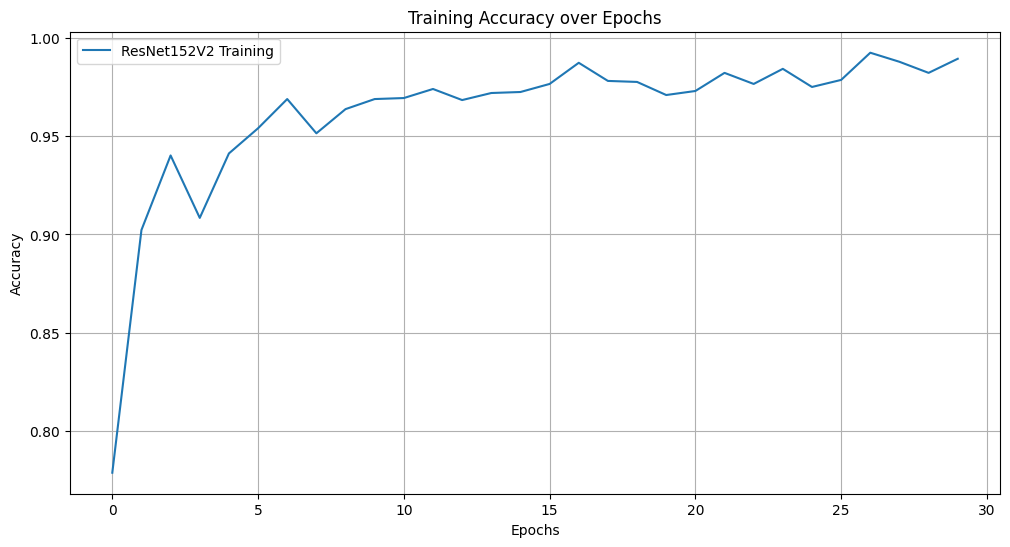

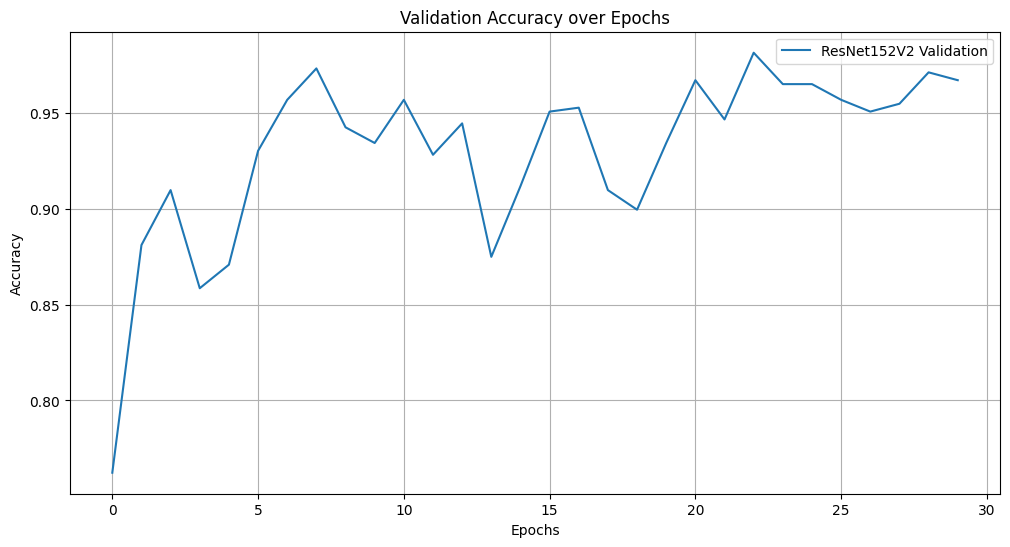

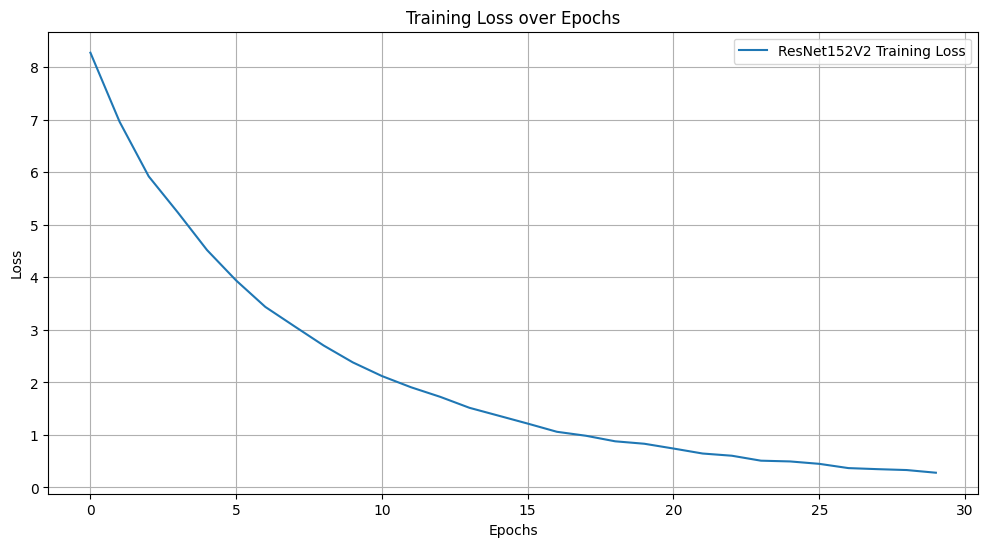

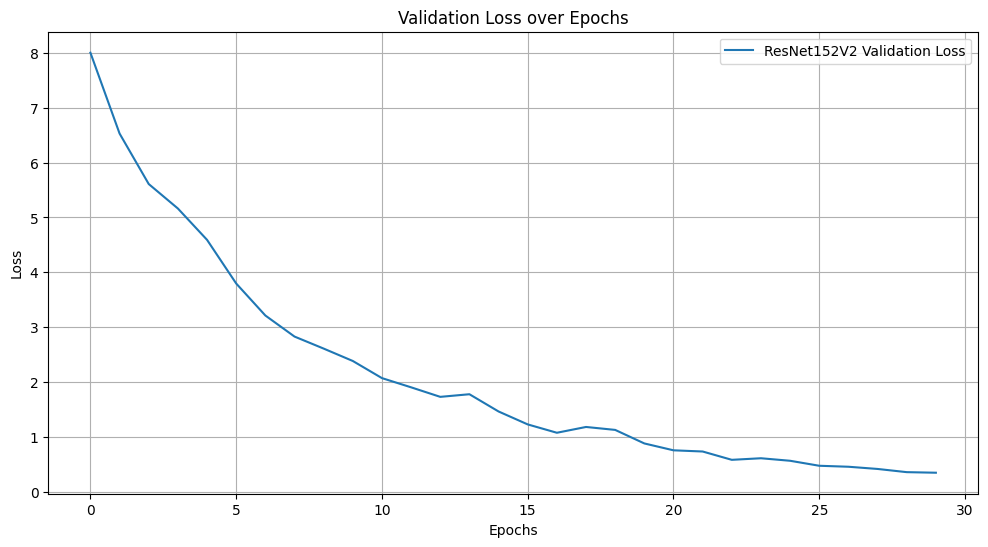

In [ ]:
# Define model names
model_names = ["ResNet152V2"]

# Store histories in a list
histories = [history3]

# Plot Training Accuracy
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'{model_names[i]} Training')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['val_accuracy'], label=f'{model_names[i]} Validation')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training Loss
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'{model_names[i]} Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Validation Loss
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['val_loss'], label=f'{model_names[i]} Validation Loss')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# # After training model(s)
evaluate_model(model3, test_ds, 'model3_resnet152v2_class_weights')
# evaluate_model(model1, test_ds, 'model1_inceptionv3_class_weights')
# evaluate_model(model2, test_ds, 'model2_efficientnetv2l_class_weights')
# evaluate_model(model4, test_ds, 'model4_xception_class_weights')
# evaluate_model(model5, test_ds, 'model5_vgg16_class_weights')
# evaluate_model(model6, test_ds, 'model6_mobilenetv2_class_weights')

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1919']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

TypeError: got an unexpected keyword argument 'squared'

# Load models (STOP, Below is still in construction...)

In [ ]:
model1 = load_model('/kaggle/working/model1_inceptionv3_class_weights.keras')
model2 = load_model('/kaggle/working/model2_efficientnetv2l_class_weights.keras')
model3 = load_model('/kaggle/working/model3_resnet152v2_class_weights.keras')
model4 = load_model('/kaggle/working/model4_xception_class_weights.keras')
model5 = load_model('/kaggle/working/model5_vgg16_class_weights.keras')
model6 = load_model('/kaggle/working/model6_mobilenetv2_class_weights.keras')

In [ ]:
# Define ensembles
ensemble1 = [model2, model4, model3]
ensemble2 = [model1, model2, model4]
ensemble3 = [model2, model3, model6]

In [ ]:
def ensemble_predict(models, test_ds):
    all_predictions = []
    y_true = []

    for images, labels in test_ds:
        y_true.extend(labels.numpy())
        preds = [model.predict(images, verbose=0) for model in models]
        all_predictions.append(np.mean(preds, axis=0))

    avg_predictions = np.vstack(all_predictions)
    final_predictions = np.argmax(avg_predictions, axis=1)
    return np.array(y_true), final_predictions, avg_predictions


In [ ]:
# Function to evaluate ensemble and save results
def evaluate_and_save_ensemble(models, test_ds, model_name):
    y_true, y_pred, avg_probs = ensemble_predict(models, test_ds)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    specificity = np.mean(np.diag(cm) / np.sum(cm, axis=0))

    # Additional metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    # Print evaluation metrics
    print(f"\n=== Model Evaluation Metrics for {model_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Save results
    with open(f'{model_name}_results.pkl', 'wb') as f:
        pickle.dump({'y_true': y_true, 'y_pred': y_pred, 'avg_probs': avg_probs}, f)

    print(f"Ensemble '{model_name}' results saved successfully!")

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [ ]:
# Run evaluation for all ensembles
evaluate_and_save_ensemble(ensemble1, test_ds, "ensemble1")
evaluate_and_save_ensemble(ensemble2, test_ds, "ensemble2")
evaluate_and_save_ensemble(ensemble3, test_ds, "ensemble3")

In [ ]:
ensembles = ["Ensemble 1", "Ensemble 2", "Ensemble 3"]
accuracy = [0.9947, 0.9924, 0.9908]
precision = [0.9945, 0.9920, 0.9904]
recall = [0.9946, 0.9921, 0.9905]
f1_score = [0.9945, 0.9921, 0.9904]
sensitivity = [0.9946, 0.9921, 0.9905]
specificity = [0.9945, 0.9920, 0.9904]
mae = [0.0076, 0.0137, 0.0130]
rmse = [0.1172, 0.1747, 0.1487]


colors = ["#203f85", "#1eb4cb", "#fdf6de", "#f03c29", "#fbd022"]


plt.figure(figsize=(8, 5))
plt.bar(ensembles, accuracy, color=colors[1])
plt.xlabel("Ensemble Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Ensemble Models")
plt.ylim(0.98, 1.0)
for i, v in enumerate(accuracy):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=12, color='black')
plt.show()


metrics = [precision, recall, f1_score]
labels = ["Precision", "Recall", "F1 Score"]
metric_colors = [colors[0], colors[3], colors[4]]

plt.figure(figsize=(8, 5))
bar_width = 0.25
x = np.arange(len(ensembles))

for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, metric, width=bar_width, label=labels[i], color=metric_colors[i])

plt.xlabel("Ensemble Models")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score Comparison")
plt.xticks(x + bar_width, ensembles)
plt.legend()
plt.ylim(0.98, 1.0)
plt.show()


plt.figure(figsize=(8, 5))
bar_width = 0.25
x = np.arange(len(ensembles))

plt.bar(x, mae, width=bar_width, label="MAE", color=colors[3])
plt.bar(x + bar_width, rmse, width=bar_width, label="RMSE", color=colors[1])

plt.xlabel("Ensemble Models")
plt.ylabel("Error")
plt.title("MAE and RMSE Comparison")
plt.xticks(x + bar_width / 2, ensembles)
plt.legend()
plt.show()
